## This final code file mainly does three things:

1. Extract tickers and dates based on the filenames in the 'cleaned_data' folder, and store them in a dataframe called 'df'

2. Download the stock returns and market returns (sp500 index returns) based on the tickers and filing_dates. 
    
    Calculate the beta values for each stock using data 12-days prior to the filing date.
    
    Then Calculate the three-day excess returns 

3. Return analysis

    Rank each method of the negativity scores, and divide them into 5 quantiles.
    
    Finally, plot the negativity scores with the excess returns to derive insights

    Compare the two methods proportional weighting & term weighting

## Extract tickers & dates

In [246]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta

In [333]:
# retrieve the ticker & filing_date based on the filenames in the 'cleaned_data' folder
# store the extracted valid info in 'df'
base_path = r"D:\NLP-HW1\cleaned_data"
filenames = os.listdir(base_path)

tickers = []
filing_dates = []

# Loop through the filenames 
for filename in filenames:
    parts = filename.split('-')
    # extract ticker and its corresponding filing_date
    ticker = parts[1]
    filing_date = filename[-14:-4]
    tickers.append(ticker)
    filing_dates.append(filing_date)

# Create a DataFrame
data = {'Ticker': tickers, 'Filing_Date': filing_dates}
df = pd.DataFrame(data)
df.head()

,Ticker,Filing_Date
0,HSIC,2018-05-08
1,HSIC,2018-08-06
2,HSIC,2018-11-06
3,HSIC,2019-05-07
4,HSIC,2019-08-06


## Download excess returns

This part mainly downloads excess returns based on the specific stock tickers and filing dates.
Say we denote the filing date as t=0.

Then the excess return is defined as:

$$Excess Return_i = \sum_{t=1} ^{t=3} R_i - \beta_i * \sum_{t=1} ^{t=3} R_m$$

To obtain $\beta_i$, we have to run one step prior:
$$R_i = \alpha_i + \beta_i * R_m $$

We have to obtain a time series of the specific stock ticker returns and market returns series 120 days prior to t=0, and perform simple regression with them to obtain a specific beta number, and use this beta to calculate the three-day future excess returns 

In [285]:
# list of trading holidays 
trading_holidays = [
    '2017-01-01','2017-12-25',
    '2018-01-01','2018-12-25',
    '2019-01-01','2019-12-25',
    '2020-01-01','2020-12-25',
    '2021-01-01','2021-12-25',
    '2022-01-01','2022-12-25',
    '2023-01-01','2023-12-25',
]

# helper functions 
def is_trading_day(date):
    date = pd.to_datetime(date)
    
    # Check if the date is a weekend (Saturday or Sunday)
    if date.weekday() >= 5:
        return False
    
    # Check if the date is in the list of trading holidays
    if date.strftime('%Y-%m-%d') in trading_holidays:
        return False
    
    return True

def get_trading_day_or_next(date):
    date = pd.to_datetime(date)

    if is_trading_day(date):
        return date.strftime('%Y-%m-%d')
    
    # Increment the date by one day until a trading day is found
    while not is_trading_day(date):
        date += pd.Timedelta(days=1)
    
    return date.strftime('%Y-%m-%d')

# Obtain valid slice of market return series based on a specific filing date 
def get_mkt_returns(mkt_returns, data):
    filing_date = data['Filing_Date']

    # If the filing_date is not in the indexes of mkt_returns, move on to the next date until find a valid one
    while filing_date not in mkt_returns.index: 
        # get the next nearest date possible 
        filing_date = datetime.strptime(filing_date,"%Y-%m-%d") + timedelta(days=1)
        filing_date = filing_date.strftime("%Y-%m-%d")

    # get the index (location) of where the 'filing_date'lies in the long 'mkt_returns' series     
    idx = mkt_returns.index.get_loc(filing_date)
    # get past and future dates
    past_start_date = mkt_returns.index[idx - 120]
    past_end_date = mkt_returns.index[idx]
    future_start_date = mkt_returns.index[idx + 1]
    future_end_date = mkt_returns.index[idx + 4]
    # get past and future returns 
    past_window = np.logical_and(mkt_returns.index >= past_start_date, mkt_returns.index < past_end_date)
    past_returns = mkt_returns[past_window]
    future_window = np.logical_and(mkt_returns.index >= future_start_date, mkt_returns.index < future_end_date)
    future_returns = mkt_returns[future_window]

    return past_returns, future_returns


def previous_bd(date):
    return (pd.Timestamp(date) + pd.offsets.BusinessDay(n=-1)).strftime('%Y-%m-%d')

# Obtain valid slice of stock returns based on ticker and date 
def get_ticker_returns(mkt_returns, data):
    filing_date = data['Filing_Date']
    
    # I get the dates from the market returns, as I want them to match.
    # If the filing_date is not in the indexes of mkt_returns, move on to the next date until find a valid one
    while filing_date not in mkt_returns.index: 
        # get the next nearest date possible 
        filing_date = datetime.strptime(filing_date,"%Y-%m-%d") + timedelta(days=1)
        filing_date = filing_date.strftime("%Y-%m-%d")

    # get the index (location) of where the 'filing_date'lies in the long 'mkt_returns' series 
    idx = mkt_returns.index.get_loc(filing_date)

    past_start_date  = mkt_returns.index[idx - 120]
    past_end_date  = mkt_returns.index[idx]
    future_start_date = mkt_returns.index[idx + 1]
    future_end_date = mkt_returns.index[idx + 4]
    
    # get history returns of this specific ticker 
    ticker = yf.Ticker(data['Ticker'])
    history = ticker.history(period = '1d', start = previous_bd(past_start_date), end = future_end_date)['Close']
    
    returns  = history/history.shift(1) - 1 
    returns  = returns.dropna()
    returns.index = pd.to_datetime(returns.index).strftime('%Y-%m-%d')
    returns.name  = data['Ticker']

    past_window = np.logical_and(returns.index >= past_start_date, returns.index < past_end_date)
    past_returns = returns[past_window]
    future_window = np.logical_and(returns.index >= future_start_date, returns.index < future_end_date)
    future_returns = returns[future_window]

    return past_returns, future_returns

# helper function
def align_series_by_date_index(series1, series2):
    """
    Align two pandas Series by their date indexes and keep only the matching rows.

    Parameters:
        series1 (pd.Series): The first pandas Series.
        series2 (pd.Series): The second pandas Series.

    Returns:
        aligned_series1 (pd.Series): The first Series aligned to match the date indexes.
        aligned_series2 (pd.Series): The second Series aligned to match the date indexes.
    """
    # # Ensure that both Series have datetime indexes
    # if not isinstance(series1.index, pd.DatetimeIndex) or not isinstance(series2.index, pd.DatetimeIndex):
    #     raise ValueError("Both Series must have datetime indexes.")

    # Find the common date index
    common_index = series1.index.intersection(series2.index)

    # Align the Series to the common date index
    aligned_series1 = series1.loc[common_index]
    aligned_series2 = series2.loc[common_index]

    return aligned_series1, aligned_series2

def get_beta(mkt_returns, data):
    # Define pandas series 
    series1 = get_ticker_returns(mkt_returns, data)[0]
    series2 = get_mkt_returns(mkt_returns, data)[0]

    series1, series2 = align_series_by_date_index(series1, series2)
    # Add a constant (intercept term) to the series 
    series1 = sm.add_constant(series1)

    # Fit the model 
    model = sm.OLS(series2, series1)
    results = model.fit()

    # beta (slope) is in the second position
    beta = results.params[data['Ticker']]
    return beta 


In [334]:
# obtain a long slice of historical sp500 returns 
sp500 = yf.Ticker('^GSPC')
# sp500.info['shortName']

history = sp500.history(period = '1d', start = '2017-05-01', end = '2023-02-01')['Close']
# history
mkt_returns = history/history.shift(1) - 1
mkt_returns = mkt_returns.dropna()
mkt_returns.index = mkt_returns.index.strftime('%Y-%m-%d')
mkt_returns.name = 'Market_Returns'
mkt_returns.head()

Date
2017-05-02    0.001189
2017-05-03   -0.001271
2017-05-04    0.000582
2017-05-05    0.004089
2017-05-08    0.000037
Name: Market_Returns, dtype: float64

In [331]:
# Testing 
# get_mkt_returns(mkt_returns,df.loc[0])[0]
# mkt_future_returns = get_mkt_returns(mkt_returns,df.loc[0])[1]
# ticker_future_returns = get_ticker_returns(mkt_returns,df.loc[0])[1]
# beta = get_beta(mkt_returns, df.loc[0])
# excess_returns = sum(ticker_future_returns) - beta * sum(mkt_future_returns)
# excess_returns

In [335]:
# read in negativity_scores.csv
negativity_score = pd.read_csv('negativity_scores.csv',index_col="Unnamed: 0")
negativity_score.head()

,hiv4_pw,lm_pw,hiv4_tw,lm_tw
1000228-HSIC-2018-05-08.txt,0.022767,0.034463,153.587786,254.455412
1000228-HSIC-2018-08-06.txt,0.025220,0.037101,159.971490,267.874377
1000228-HSIC-2018-11-06.txt,0.026597,0.040956,168.452773,488.237343
1000228-HSIC-2019-05-07.txt,0.028794,0.049216,130.977812,519.392587
1000228-HSIC-2019-08-06.txt,0.030097,0.047986,129.820982,535.075698


In [309]:
# obtain a long slice of historical sp500 returns 
sp500 = yf.Ticker('^GSPC')
# sp500.info['shortName']

history = sp500.history(period = '1d', start = '2017-05-01', end = '2023-02-01')['Close']
# history
mkt_returns = history/history.shift(1) - 1
mkt_returns = mkt_returns.dropna()
mkt_returns.index = mkt_returns.index.strftime('%Y-%m-%d')
mkt_returns.name = 'Market_Returns'

In [336]:
negativity_score['excess_returns'] = 0
negativity_score.head()

,hiv4_pw,lm_pw,hiv4_tw,lm_tw,excess_returns
1000228-HSIC-2018-05-08.txt,0.022767,0.034463,153.587786,254.455412,0
1000228-HSIC-2018-08-06.txt,0.025220,0.037101,159.971490,267.874377,0
1000228-HSIC-2018-11-06.txt,0.026597,0.040956,168.452773,488.237343,0
1000228-HSIC-2019-05-07.txt,0.028794,0.049216,130.977812,519.392587,0
1000228-HSIC-2019-08-06.txt,0.030097,0.047986,129.820982,535.075698,0


In [311]:
# Debugging (some symbols might be delisted)
# 392, 'ISRG', '2019-04-19'
# 1154, 'RE', '2018-05-10'

for i in range(len(df)):
    mkt_past_returns = get_mkt_returns(mkt_returns,df.loc[i])[0]
    ticker_past_returns = get_ticker_returns(mkt_returns,df.loc[i])[0]
    
    # if any of the mkt_returns or ticker_returns is empty (symbol might be delisted),
    # Then assign a nan value to the excess_return as a placeholder to later dropna
    if mkt_past_returns.empty or ticker_past_returns.empty:
        excess_returns = np.nan 
        negativity_score.iat[i,4] = excess_returns
    else:
        beta = get_beta(mkt_returns, df.loc[i])
        mkt_future_returns = get_mkt_returns(mkt_returns,df.loc[i])[1]
        ticker_future_returns = get_ticker_returns(mkt_returns,df.loc[i])[1]
        excess_returns = sum(ticker_future_returns) - beta * sum(mkt_future_returns)
        negativity_score.iat[i,4] = excess_returns
    print(f"{i}th Excess return is {excess_returns}: ")
    
negativity_score

0th Excess return is 0.0199492950033526: 
1th Excess return is -0.04503381406969171: 
2th Excess return is 0.02148053740066106: 
3th Excess return is 0.033128361831834575: 
4th Excess return is 0.017736276970739515: 
5th Excess return is 0.015622390746272688: 
6th Excess return is -0.00956514287814541: 
7th Excess return is -0.027406817029558647: 
8th Excess return is -0.02911329104086227: 
9th Excess return is 0.0067183708648720485: 
10th Excess return is -0.042173664278464716: 
11th Excess return is 0.020190519692705307: 
12th Excess return is 0.05044659500618246: 
13th Excess return is -0.008330277780925936: 
14th Excess return is 0.029268786978124656: 
15th Excess return is 0.047299577787366064: 
16th Excess return is 0.04813632981186346: 
17th Excess return is -0.010395445159069656: 
18th Excess return is 0.0011466140654514236: 
19th Excess return is -0.1425244896751674: 
20th Excess return is 0.03726841519854136: 
21th Excess return is 0.08177757314691729: 
22th Excess return is 

RE: No timezone found, symbol may be delisted
RE: No timezone found, symbol may be delisted


1153th Excess return is 0.037171624546409876: 
1154th Excess return is nan: 
1155th Excess return is nan: 


RE: No timezone found, symbol may be delisted
RE: No timezone found, symbol may be delisted
RE: No timezone found, symbol may be delisted


1156th Excess return is nan: 
1157th Excess return is nan: 
1158th Excess return is nan: 


RE: No timezone found, symbol may be delisted
RE: No timezone found, symbol may be delisted
RE: No timezone found, symbol may be delisted


1159th Excess return is nan: 
1160th Excess return is nan: 


RE: No timezone found, symbol may be delisted
RE: No timezone found, symbol may be delisted


1161th Excess return is nan: 
1162th Excess return is nan: 
1163th Excess return is nan: 


RE: No timezone found, symbol may be delisted
RE: No timezone found, symbol may be delisted
RE: No timezone found, symbol may be delisted
RE: No timezone found, symbol may be delisted


1164th Excess return is nan: 
1165th Excess return is nan: 
1166th Excess return is nan: 
1167th Excess return is nan: 


RE: No timezone found, symbol may be delisted


1168th Excess return is nan: 
1169th Excess return is 0.03619023639147153: 
1170th Excess return is -0.008976814745088749: 
1171th Excess return is -0.007313688781287123: 
1172th Excess return is 0.0019088588448631888: 
1173th Excess return is -0.06742646850949602: 
1174th Excess return is 0.021126636775738828: 
1175th Excess return is -0.003150846336166118: 
1176th Excess return is 0.008860578808937526: 
1177th Excess return is 0.12211377650496626: 
1178th Excess return is -0.02372706991632831: 
1179th Excess return is -0.031865439623380044: 
1180th Excess return is 0.027553706352738943: 
1181th Excess return is -0.0847110632116831: 
1182th Excess return is -0.06661330328724548: 
1183th Excess return is -0.033548761097996684: 
1184th Excess return is 0.002056177994117763: 
1185th Excess return is -0.0060770207955810045: 
1186th Excess return is 0.14166045741548283: 
1187th Excess return is 0.03549218486744504: 
1188th Excess return is -0.0011115313666073354: 
1189th Excess return is -

MSCI: No price data found, symbol may be delisted (1d 2020-11-02 -> 2021-05-04)


2318th Excess return is -0.0005077476823230431: 
2319th Excess return is 0.020476991592547213: 
2320th Excess return is 0.03174949551488766: 
2321th Excess return is -0.014641689934527526: 
2322th Excess return is 0.05725611315722334: 
2323th Excess return is 0.05045538182790686: 
2324th Excess return is -0.02177177871160168: 
2325th Excess return is 0.016006138508519428: 
2326th Excess return is -0.0036570115190201853: 
2327th Excess return is -3.633780515337041e-05: 
2328th Excess return is 0.00561544667842151: 
2329th Excess return is -0.008076795683947664: 
2330th Excess return is 0.002509330817139943: 
2331th Excess return is 0.0069632775224286415: 
2332th Excess return is 0.03178223826643072: 
2333th Excess return is -0.015294324523045697: 
2334th Excess return is 0.0407665589592813: 
2335th Excess return is -0.04217326319224673: 
2336th Excess return is -0.04497922780433116: 
2337th Excess return is 0.023182680905651884: 
2338th Excess return is -0.028394360742903933: 
2339th Ex

BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


2498th Excess return is 0.04401874056143231: 
2499th Excess return is nan: 
2500th Excess return is nan: 
2501th Excess return is nan: 


BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


2502th Excess return is nan: 
2503th Excess return is nan: 
2504th Excess return is nan: 
2505th Excess return is nan: 


BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


2506th Excess return is nan: 
2507th Excess return is nan: 
2508th Excess return is nan: 


BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


2509th Excess return is nan: 
2510th Excess return is nan: 
2511th Excess return is nan: 


BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
BF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


2512th Excess return is nan: 
2513th Excess return is nan: 
2514th Excess return is 0.028017085961744126: 
2515th Excess return is -0.014750830070376246: 
2516th Excess return is 0.006038367200022848: 
2517th Excess return is -0.01101152906558045: 
2518th Excess return is 0.00918278876437131: 
2519th Excess return is -0.003354090740387122: 
2520th Excess return is 0.031255132481790515: 
2521th Excess return is 0.07486424675327535: 
2522th Excess return is 0.04002687159283168: 
2523th Excess return is 0.043925522411831244: 
2524th Excess return is 0.03178442983371681: 
2525th Excess return is -0.02705112291343364: 
2526th Excess return is -0.05253655366788467: 
2527th Excess return is 0.053964481591096694: 
2528th Excess return is 0.11812920582038607: 
2529th Excess return is -0.0031592689710689126: 
2530th Excess return is 0.014080593247292845: 
2531th Excess return is 0.001622431560422162: 
2532th Excess return is -0.006919545806642008: 
2533th Excess return is -0.008293506351022393: 

PKI: No timezone found, symbol may be delisted
PKI: No timezone found, symbol may be delisted
PKI: No timezone found, symbol may be delisted


3826th Excess return is -0.03851240445596654: 
3827th Excess return is nan: 
3828th Excess return is nan: 


PKI: No timezone found, symbol may be delisted


3829th Excess return is nan: 
3830th Excess return is nan: 


PKI: No timezone found, symbol may be delisted
PKI: No timezone found, symbol may be delisted
PKI: No timezone found, symbol may be delisted
PKI: No timezone found, symbol may be delisted


3831th Excess return is nan: 
3832th Excess return is nan: 
3833th Excess return is nan: 


PKI: No timezone found, symbol may be delisted


3834th Excess return is nan: 
3835th Excess return is nan: 


PKI: No timezone found, symbol may be delisted
PKI: No timezone found, symbol may be delisted
PKI: No timezone found, symbol may be delisted
PKI: No timezone found, symbol may be delisted


3836th Excess return is nan: 
3837th Excess return is nan: 
3838th Excess return is nan: 


PKI: No timezone found, symbol may be delisted


3839th Excess return is nan: 
3840th Excess return is nan: 


PKI: No timezone found, symbol may be delisted


3841th Excess return is nan: 
3842th Excess return is -0.0035207641105102277: 
3843th Excess return is 0.019083142017696963: 
3844th Excess return is -0.0185266767475204: 
3845th Excess return is 0.0037899409747460073: 
3846th Excess return is -0.011739981677544871: 
3847th Excess return is 0.014856941950988588: 
3848th Excess return is 0.01906740168544502: 
3849th Excess return is -0.014266804941868654: 
3850th Excess return is 0.004922086037145814: 
3851th Excess return is 0.03565515909978823: 
3852th Excess return is -0.0029068004197084236: 
3853th Excess return is -0.03322501482447721: 
3854th Excess return is -0.015352732256295127: 
3855th Excess return is 0.015206948883437666: 
3856th Excess return is 0.07897237681309038: 
3857th Excess return is -0.03034953468712021: 
3858th Excess return is 0.0041664455518741605: 
3859th Excess return is 0.009440919446194199: 
3860th Excess return is 0.04986641886709389: 
3861th Excess return is -0.04124086938113375: 
3862th Excess return is 0.

SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted


4951th Excess return is -0.009998782142841375: 
4952th Excess return is nan: 
4953th Excess return is nan: 


SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted


4954th Excess return is nan: 
4955th Excess return is nan: 
4956th Excess return is nan: 


SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted


4957th Excess return is nan: 
4958th Excess return is nan: 
4959th Excess return is nan: 


SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted


4960th Excess return is nan: 
4961th Excess return is nan: 
4962th Excess return is nan: 


SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted


4963th Excess return is nan: 
4964th Excess return is nan: 
4965th Excess return is nan: 
4966th Excess return is nan: 
4967th Excess return is 0.019385500378746166: 
4968th Excess return is 0.008526304869393474: 
4969th Excess return is -0.021092143692149054: 
4970th Excess return is 0.008991670317069494: 
4971th Excess return is -0.022391448226231743: 
4972th Excess return is -0.01309526791359153: 
4973th Excess return is 0.028580931872979755: 
4974th Excess return is -0.09429316702171317: 
4975th Excess return is 0.015952180867708308: 
4976th Excess return is 0.02900050426556622: 
4977th Excess return is -0.04135643792264875: 
4978th Excess return is 0.025256820095513305: 
4979th Excess return is -0.02193648318475229: 
4980th Excess return is -0.010162749559622545: 
4981th Excess return is 0.04352655914678247: 
4982th Excess return is -0.018349745316666305: 
4983th Excess return is 0.043699034707332836: 
4984th Excess return is 0.01889484186331133: 
4985th Excess return is -0.000383

FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted


5641th Excess return is -0.009993836012594893: 
5642th Excess return is nan: 
5643th Excess return is nan: 


FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted


5644th Excess return is nan: 
5645th Excess return is nan: 
5646th Excess return is nan: 


FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted


5647th Excess return is nan: 
5648th Excess return is nan: 
5649th Excess return is nan: 
5650th Excess return is nan: 


FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted


5651th Excess return is nan: 
5652th Excess return is nan: 
5653th Excess return is nan: 
5654th Excess return is nan: 


FISV: No timezone found, symbol may be delisted
FISV: No timezone found, symbol may be delisted


5655th Excess return is nan: 
5656th Excess return is nan: 
5657th Excess return is -0.03500256511426615: 
5658th Excess return is 0.03208275501029528: 
5659th Excess return is -0.03064914365813161: 
5660th Excess return is -0.017882590504439383: 
5661th Excess return is -6.292876751804854e-05: 
5662th Excess return is -0.0009394342261814376: 
5663th Excess return is -0.02831817854029527: 
5664th Excess return is -0.011882406949520584: 
5665th Excess return is -0.005417089695907628: 
5666th Excess return is 0.03736009609519774: 
5667th Excess return is 0.022422778734780477: 
5668th Excess return is -0.02028953872517799: 
5669th Excess return is -0.01548488827707316: 
5670th Excess return is -0.014033846900018486: 
5671th Excess return is 0.01270040246563502: 
5672th Excess return is -0.01583623902988865: 
5673th Excess return is -0.02108285943671974: 
5674th Excess return is 0.03725307501604197: 
5675th Excess return is -0.014631184582398163: 
5676th Excess return is 0.0250114238446334

,hiv4_pw,lm_pw,hiv4_tw,lm_tw,excess_returns
1000228-HSIC-2018-05-08.txt,0.022767,0.034463,153.587786,254.455412,0.019949
1000228-HSIC-2018-08-06.txt,0.025220,0.037101,159.971490,267.874377,-0.045034
1000228-HSIC-2018-11-06.txt,0.026597,0.040956,168.452773,488.237343,0.021481
1000228-HSIC-2019-05-07.txt,0.028794,0.049216,130.977812,519.392587,0.033128
1000228-HSIC-2019-08-06.txt,0.030097,0.047986,129.820982,535.075698,0.017736
...,...,...,...,...,...
97745-TMO-2021-08-06.txt,0.016778,0.018705,6.619789,19.723620,-0.001999
97745-TMO-2021-11-04.txt,0.017377,0.018101,6.691678,20.244582,-0.033008
97745-TMO-2022-05-06.txt,0.018746,0.015050,4.684456,8.200379,-0.027245
97745-TMO-2022-08-05.txt,0.018794,0.014645,4.710818,8.011015,-0.004329


In [314]:
# Count the number of rows with NaN values
nan_count = negativity_score.isna().sum(axis=0)
nan_count

hiv4_pw            0
lm_pw              0
hiv4_tw            0
lm_tw              0
excess_returns    75
dtype: int64

In [315]:
# drop the rows that have 'NA' values in the 'excess_returns' column
# Obtain a new dataframe 'scores_cleaned' which doesn't have NA values 
scores_cleaned = negativity_score.dropna()
print(len(scores_cleaned))
scores_cleaned

7245


,hiv4_pw,lm_pw,hiv4_tw,lm_tw,excess_returns
1000228-HSIC-2018-05-08.txt,0.022767,0.034463,153.587786,254.455412,0.019949
1000228-HSIC-2018-08-06.txt,0.025220,0.037101,159.971490,267.874377,-0.045034
1000228-HSIC-2018-11-06.txt,0.026597,0.040956,168.452773,488.237343,0.021481
1000228-HSIC-2019-05-07.txt,0.028794,0.049216,130.977812,519.392587,0.033128
1000228-HSIC-2019-08-06.txt,0.030097,0.047986,129.820982,535.075698,0.017736
...,...,...,...,...,...
97745-TMO-2021-08-06.txt,0.016778,0.018705,6.619789,19.723620,-0.001999
97745-TMO-2021-11-04.txt,0.017377,0.018101,6.691678,20.244582,-0.033008
97745-TMO-2022-05-06.txt,0.018746,0.015050,4.684456,8.200379,-0.027245
97745-TMO-2022-08-05.txt,0.018794,0.014645,4.710818,8.011015,-0.004329


In [338]:
scores_cleaned.to_csv('scores_cleaned.csv')

## Return Analysis 

In [316]:
scores_cleaned.columns

Index(['hiv4_pw', 'lm_pw', 'hiv4_tw', 'lm_tw', 'excess_returns'], dtype='object')

In [319]:
df_rank = scores_cleaned.copy()
df_rank['hiv4_pw_rank'] = df_rank['hiv4_pw'].rank(method='first')
df_rank['lm_pw_rank'] = df_rank['lm_pw'].rank(method='first')
df_rank['hiv4_tw_rank'] = df_rank['hiv4_tw'].rank(method='first')
df_rank['lm_tw_rank'] = df_rank['lm_tw'].rank(method='first')
df_rank

,hiv4_pw,lm_pw,hiv4_tw,lm_tw,excess_returns,lm_pw_rank,hiv4_pw_rank,hiv4_tw_rank,lm_tw_rank
1000228-HSIC-2018-05-08.txt,0.022767,0.034463,153.587786,254.455412,0.019949,6013.0,3493.0,6511.0,6135.0
1000228-HSIC-2018-08-06.txt,0.025220,0.037101,159.971490,267.874377,-0.045034,6335.0,4634.0,6545.0,6255.0
1000228-HSIC-2018-11-06.txt,0.026597,0.040956,168.452773,488.237343,0.021481,6660.0,5195.0,6584.0,6899.0
1000228-HSIC-2019-05-07.txt,0.028794,0.049216,130.977812,519.392587,0.033128,7043.0,5891.0,6312.0,6935.0
1000228-HSIC-2019-08-06.txt,0.030097,0.047986,129.820982,535.075698,0.017736,7003.0,6250.0,6296.0,6957.0
...,...,...,...,...,...,...,...,...,...
97745-TMO-2021-08-06.txt,0.016778,0.018705,6.619789,19.723620,-0.001999,2186.0,781.0,677.0,731.0
97745-TMO-2021-11-04.txt,0.017377,0.018101,6.691678,20.244582,-0.033008,1960.0,968.0,691.0,766.0
97745-TMO-2022-05-06.txt,0.018746,0.015050,4.684456,8.200379,-0.027245,1006.0,1548.0,321.0,143.0
97745-TMO-2022-08-05.txt,0.018794,0.014645,4.710818,8.011015,-0.004329,910.0,1568.0,325.0,126.0


In [320]:
bin_labels = ['5','4','3','2','1']
df_rank['hiv4_pw_quantile'] = pd.qcut(df_rank['hiv4_pw_rank'].astype(int),5,labels=bin_labels)
df_rank['lm_pw_quantile'] = pd.qcut(df_rank['lm_pw_rank'].astype(int),5,labels=bin_labels)
df_rank['hiv4_tw_quantile'] = pd.qcut(df_rank['hiv4_tw_rank'].astype(int),5,labels=bin_labels)
df_rank['lm_tw_quantile'] = pd.qcut(df_rank['lm_tw_rank'].astype(int),5,labels=bin_labels)
# df_rank

,hiv4_pw,lm_pw,hiv4_tw,lm_tw,excess_returns,lm_pw_rank,hiv4_pw_rank,hiv4_tw_rank,lm_tw_rank,hiv4_pw_quantile,lm_pw_quantile,hiv4_tw_quantile,lm_tw_quantile
1000228-HSIC-2018-05-08.txt,0.022767,0.034463,153.587786,254.455412,0.019949,6013.0,3493.0,6511.0,6135.0,3,1,1,1
1000228-HSIC-2018-08-06.txt,0.025220,0.037101,159.971490,267.874377,-0.045034,6335.0,4634.0,6545.0,6255.0,2,1,1,1
1000228-HSIC-2018-11-06.txt,0.026597,0.040956,168.452773,488.237343,0.021481,6660.0,5195.0,6584.0,6899.0,2,1,1,1
1000228-HSIC-2019-05-07.txt,0.028794,0.049216,130.977812,519.392587,0.033128,7043.0,5891.0,6312.0,6935.0,1,1,1,1
1000228-HSIC-2019-08-06.txt,0.030097,0.047986,129.820982,535.075698,0.017736,7003.0,6250.0,6296.0,6957.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97745-TMO-2021-08-06.txt,0.016778,0.018705,6.619789,19.723620,-0.001999,2186.0,781.0,677.0,731.0,5,4,5,5
97745-TMO-2021-11-04.txt,0.017377,0.018101,6.691678,20.244582,-0.033008,1960.0,968.0,691.0,766.0,5,4,5,5
97745-TMO-2022-05-06.txt,0.018746,0.015050,4.684456,8.200379,-0.027245,1006.0,1548.0,321.0,143.0,4,5,5,5
97745-TMO-2022-08-05.txt,0.018794,0.014645,4.710818,8.011015,-0.004329,910.0,1568.0,325.0,126.0,4,5,5,5


In [321]:
df_rank.columns

Index(['hiv4_pw', 'lm_pw', 'hiv4_tw', 'lm_tw', 'excess_returns', 'lm_pw_rank',
       'hiv4_pw_rank', 'hiv4_tw_rank', 'lm_tw_rank', 'hiv4_pw_quantile',
       'lm_pw_quantile', 'hiv4_tw_quantile', 'lm_tw_quantile'],
      dtype='object')

In [322]:
quantile = df_rank[['excess_returns','hiv4_pw_quantile','lm_pw_quantile', 
                    'hiv4_tw_quantile', 'lm_tw_quantile']]
quantile.head()

,excess_returns,hiv4_pw_quantile,lm_pw_quantile,hiv4_tw_quantile,lm_tw_quantile
1000228-HSIC-2018-05-08.txt,0.019949,3,1,1,1
1000228-HSIC-2018-08-06.txt,-0.045034,2,1,1,1
1000228-HSIC-2018-11-06.txt,0.021481,2,1,1,1
1000228-HSIC-2019-05-07.txt,0.033128,1,1,1,1
1000228-HSIC-2019-08-06.txt,0.017736,1,1,1,1


In [323]:
hiv4_pw_quantile = quantile.groupby(['hiv4_pw_quantile']).median()
hiv4_pw_quantile

,excess_returns
hiv4_pw_quantile,
5,0.000395
4,0.000674
3,0.000921
2,0.003596
1,0.003508


In [325]:
lm_pw_quantile = quantile.groupby(['lm_pw_quantile']).median()
lm_pw_quantile

,excess_returns
lm_pw_quantile,
5,0.000163
4,0.000705
3,0.001481
2,0.003516
1,0.003064


In [324]:
hiv4_tw_quantile = quantile.groupby(['hiv4_tw_quantile']).median()
hiv4_tw_quantile

,excess_returns
hiv4_tw_quantile,
5,0.001030
4,0.003208
3,0.000252
2,0.001579
1,0.003354


In [326]:
lm_tw_quantile = quantile.groupby(['lm_tw_quantile']).median()
lm_tw_quantile

,excess_returns
lm_tw_quantile,
5,-0.000153
4,0.002462
3,0.000872
2,0.002663
1,0.003064


Text(0.5, 1.0, 'Term Weighted')

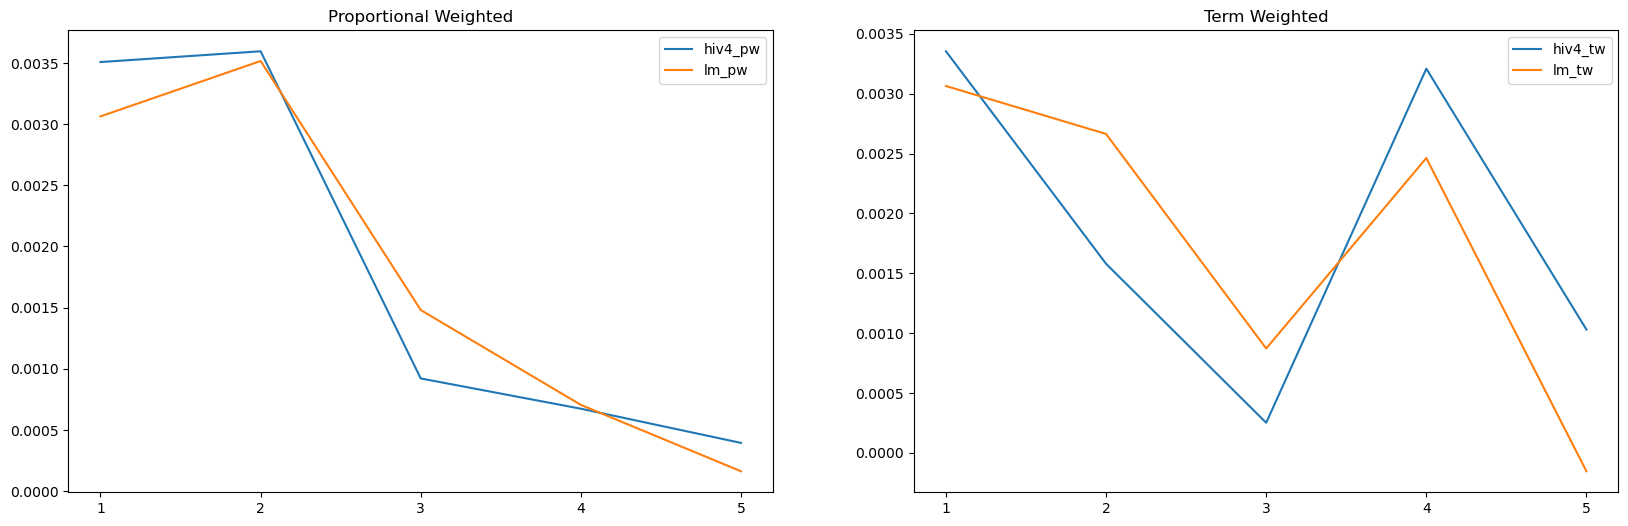

In [329]:
# plotting 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))
ax1.plot(hiv4_pw_quantile, label='hiv4_pw')
ax1.plot(lm_pw_quantile, label="lm_pw")
ax1.invert_xaxis()
ax1.legend()
ax1.set_title("Proportional Weighted")

ax2.plot(hiv4_tw_quantile, label="hiv4_tw")
ax2.plot(lm_tw_quantile, label="lm_tw")
ax2.invert_xaxis()
ax2.legend()
ax2.set_title("Term Weighted")

In the plot above, 1 is the least negative, 5 is the most negative. If the model is perfect, it should show a downward sloping trend.

In the proportional weighting plot on the left, we can see that both lines show a general decreasing trend. And there doesn't seem to have a big difference between using the hiv4 or the lm negative word dictionary. 

In the term weighting plot on the right, to my surprise, the results are not better than the proportional weighting method. It seems that from score 1~3, with the increase of the negativity score, the excess returns is on an obvious decline trend, but then suddenly from 3~4, it exhibits the inverse trend where the excess returns increase with the negativity sentiment, which is kind of counterintuitive. 

Possible explanations and reflections upon this results can be summarized as:

* Data: there should've been 10,000 10-Q files avaible, but I was just able to download 7320 files.  
* There might be issues with preprocessing the raw txt files, even though they do exhibited as cleaned text files. 
* The returns might perform in an unusual way since our timeframe is set between 2018~2022, during which covid took place between 2020~2022, which might pose abnormal behaviours in the returns in both the market and specific companies 